# Define model based on VGG-16



In [1]:
# input=[BS,3,H,W]
# output=[BS,7,H,W]
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

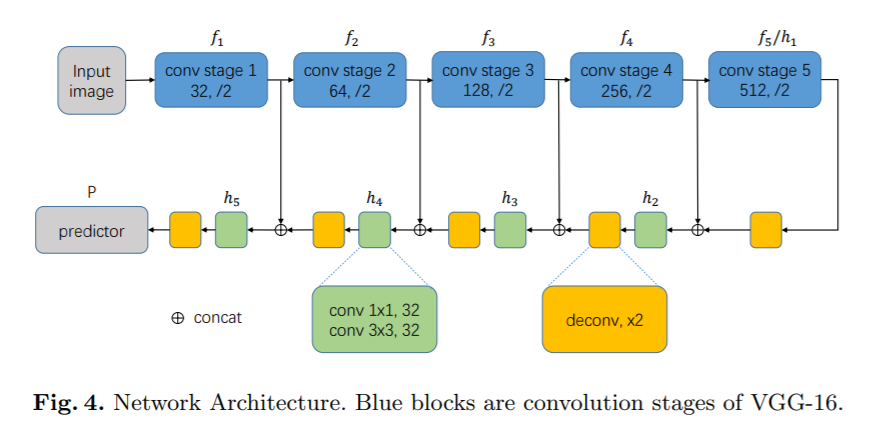

# まずはVGG-16のパスを作成する。

論文中の実装ではVGG16のフィルタ数はステージ毎に32,64,128,256,512となっているが、
これはpytorchでは一般的な実装ではない。

torchvisionに用意されているVGG16モデルに従って実装を行う場合と論文のVGG16構造の２種類を用意する。
（VGG16のフィルタ数はステージ毎に64,128,256,512,512）
torchvisionのほうが計算コストは増えるが、pretrain weightsを使用できるため精度は向上すると考える。

参考repoもpytorch VGG16に則った実装をしていた。
https://github.com/princewang1994/TextSnake.pytorch/blob/b4ee996d5a4d214ed825350d6b307dd1c31faa07/network/vgg.py#L77


In [2]:
# 論文実装のVGG16構造
def Paper_VGG16():
    layers = []
    in_channels = 3    
    # VGGのモデル構造を記入
    cfg = [32, 32, "M", 64, 64, "M", 128, 128, 128, "MC", 256, 256, 256, "M", 512, 512, 512, "M"]    
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == "MC":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)] #メモリ節約
            in_channels = v
    return nn.ModuleList(layers)

# FPN用に各Maxpooling後の出力を取り出せるようなBackboneに変更
class VGG16(nn.Module):
    def __init__(self, pretrain=True, original=False):
        super().__init__()        
        if not original:
            # Torchvisionモデルを使用        
            basemodel = torchvision.models.vgg16(pretrained=pretrain)
            # 各ステージを実装
            self.stage1 = nn.Sequential(*[basemodel.features[layer] for layer in range(0, 5)])
            self.stage2 = nn.Sequential(*[basemodel.features[layer] for layer in range(5, 10)])
            self.stage3 = nn.Sequential(*[basemodel.features[layer] for layer in range(10, 17)])
            self.stage4 = nn.Sequential(*[basemodel.features[layer] for layer in range(17, 24)])
            self.stage5 = nn.Sequential(*[basemodel.features[layer] for layer in range(24, 31)])
        elif original:
            # 論文VGG16を使用
            basemodel = Paper_VGG16()
            self.stage1 = nn.Sequential(*[basemodel[layer] for layer in range(0, 5)])
            self.stage2 = nn.Sequential(*[basemodel[layer] for layer in range(5, 10)])
            self.stage3 = nn.Sequential(*[basemodel[layer] for layer in range(10, 17)])
            self.stage4 = nn.Sequential(*[basemodel[layer] for layer in range(17, 24)])
            self.stage5 = nn.Sequential(*[basemodel[layer] for layer in range(24, 31)])

    def forward(self, x):
        C1 = self.stage1(x)
        C2 = self.stage2(C1)
        C3 = self.stage3(C2)
        C4 = self.stage4(C3)
        C5 = self.stage5(C4)
        return C1,C2,C3,C4,C5

In [31]:
class Resnet50(nn.Module):
    def __init__(self, pretrain=True):
        super().__init__()        
        # Torchvisionモデルを使用        
        basemodel = torchvision.models.resnet50(pretrain)
        self.stage1 = nn.Sequential(*list(basemodel.children())[0:3])
        self.stage2 = nn.Sequential(*list(basemodel.children())[3:5])
        self.stage3 = nn.Sequential(*list(basemodel.children())[5:6])
        self.stage4 = nn.Sequential(*list(basemodel.children())[6:7])
        self.stage5 = nn.Sequential(*list(basemodel.children())[7:8])


    def forward(self, x):
        C1 = self.stage1(x)
        C2 = self.stage2(C1)
        C3 = self.stage3(C2)
        C4 = self.stage4(C3)
        C5 = self.stage5(C4)
        return C1,C2,C3,C4,C5

In [32]:
# ダミー画像を入力しVGG出力をテスト
model = Resnet50(pretrain=True)
inputs = torch.randn(1,3,512,512)
outputs = model(inputs)
print(outputs[0].size())
print(outputs[1].size())
print(outputs[2].size())
print(outputs[3].size())
print(outputs[4].size())

torch.Size([1, 64, 256, 256])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])


# 次にUpsampleクラスとTextNetを作成する

In [33]:
# 論文にあるupsampleパスを実装
# Conv1x1 -> Conv3x3 -> Deconv2x
# https://github.com/princewang1994/TextSnake.pytorch/blob/master/network/textnet.py
# deconvのカーネルサイズは論文中には書いてない。
# TODO:元論文では他論文との比較のため、BatchNormが入っていないので学習が不安定になる。
# 精度向上のためにはBatchNormを加えたほうが良い。
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.deconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, upsampled, shortcut):
        # ショートカットした特徴量とアップサンプルされた特徴量を足し合わせる
        x = torch.cat([upsampled, shortcut], dim=1)
        x = self.conv1x1(x)
        x = F.relu(x)
        x = self.conv3x3(x)
        x = F.relu(x)
        x = self.deconv(x)
        # アップサンプルパスを出力
        return x
    
# Upsample with batchnorm
class Upsample_BN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.deconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, upsampled, shortcut):
        # ショートカットした特徴量とアップサンプルされた特徴量を足し合わせる
        x = torch.cat([upsampled, shortcut], dim=1)
        x = self.conv1x1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv3x3(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv(x)
        # アップサンプルパスを出力
        return x

In [34]:
# Make U-Net like FCN
class TextNet(nn.Module):
    def __init__(self, output_channel=7, pretrain=True, backbone="VGG16", original=False):
        super().__init__()
        self.output_channel = output_channel
        
        # 論文通り VGG16のみ実装する
        if backbone == "VGG16":
            self.basemodel = VGG16(pretrain=pretrain, original=original)
        elif backbone == "resnet50":
            self.basemodel = Resnet50(pretrain=pretrain)
        else:
            raise NotImplementedError(backbone)
        
        # TODO: 単なるUNETのアップサンプルパス。これをFPNに変えると精度向上する可能性あり。
        # Channel数の詳細な指定は論文になかったので経験に即した値に変更
        
        # ベースチャネル数を論文実装か否かで切り替える
        if original:
            base_channels = 16
        else:
            base_channels = 32        
        if backbone == "VGG16":
            # C5の出力のアップサンプルパス
            self.deconv5 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
            # C4出力のアップサンプルパス
            self.merge4 = Upsample(512+base_channels*16, 256)
            # C3出力のアップサンプルパス
            self.merge3 = Upsample(256+base_channels*8, 128)
            # C2出力のアップサンプルパス
            self.merge2 = Upsample(128+base_channels*4, 64)
            # C1出力のアップサンプルパス
            self.merge1 = Upsample(64+base_channels*2, base_channels)
        else:
            # C5の出力のアップサンプルパス
            self.deconv5 = nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1)
            # C4出力のアップサンプルパス
            self.merge4 = Upsample_BN(1024+1024, 512)
            # C3出力のアップサンプルパス
            self.merge3 = Upsample_BN(512+512, 256)
            # C2出力のアップサンプルパス
            self.merge2 = Upsample_BN(256+256, 64)
            # C1出力のアップサンプルパス
            self.merge1 = Upsample_BN(64+64, base_channels)
            
        # C1出力のアップサンプルおよび出力
        self.predict = nn.Sequential(
                nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(base_channels, self.output_channel, kernel_size=1, stride=1, padding=0)
            )
    def forward(self, x):
        C1,C2,C3,C4,C5 = self.basemodel(x)
        #upsample deconv5
        U5 = self.deconv5(C5)
        # merge and upsample C4
        U4 = self.merge4(U5, C4)
        # merge and upsample C3
        U3 = self.merge3(U4, C3)
        # merge and upsample C2
        U2 = self.merge2(U3, C2)
        # merge and upsample C1
        U1 = self.merge1(U2, C1)
        # Output predictions
        out = self.predict(U1)
        return out

In [35]:
# Test TextNet outputs
model = TextNet(backbone="resnet50")
inputs = torch.rand(2,3,512,512)
print(model(inputs).size())

torch.Size([2, 7, 512, 512])


In [36]:
print(model)

TextNet(
  (basemodel): Resnet50(
    (stage1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (stage2): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re